In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import os


In [10]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'InstrumentID':'first'
    })

    # 3. 整理列名称（可选）
    # df_minute.columns = ['_'.join(col).strip() for col in df_minute.columns.values]
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume','InstrumentID']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [13]:
dirpath = 'FutSF_TickKZ_CTP_Daily_202301'
direc = os.listdir(dirpath)

wholef = pd.DataFrame()
for file_name in direc:
    if 'IC' not in file_name:
        continue
    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['最新价','数量','合约代码']].copy()
    f.columns = ['price','volume','InstrumentID']
    f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
    ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
    wholef=pd.concat([wholef,ff],ignore_index=True)

# dirpath = 'data/IC'
# direc = os.listdir(dirpath)

# wholef = pd.DataFrame()
# for file_name in direc:

#     df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

#     f = df[['LastPrice','Volume','InstrumentID']].copy()
#     f.columns = ['price','volume','InstrumentID']
#     f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
#     ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
#     wholef=pd.concat([wholef,ff],ignore_index=True)


In [14]:
wholef

,datetime,open,high,low,close,volume,InstrumentID
0,2023-01-03 09:30:00,5854.2,5873.6,5851.4,5873.6,96680,IC2301
1,2023-01-03 09:31:00,5873.6,5886.0,5873.6,5886.0,208780,IC2301
2,2023-01-03 09:32:00,5886.8,5890.8,5881.8,5884.6,302202,IC2301
3,2023-01-03 09:33:00,5884.6,5890.2,5880.8,5881.4,369411,IC2301
4,2023-01-03 09:34:00,5882.0,5890.2,5882.0,5888.0,425007,IC2301
...,...,...,...,...,...,...,...
3860,2023-01-31 14:56:00,6306.0,6309.4,6305.8,6307.2,3614006,IC2302
3861,2023-01-31 14:57:00,6306.8,6306.8,6303.8,6303.8,3679468,IC2302
3862,2023-01-31 14:58:00,6304.0,6304.4,6299.6,6300.8,3782916,IC2302
3863,2023-01-31 14:59:00,6300.6,6305.6,6299.8,6302.0,3823041,IC2302


In [15]:
def turtle_backtest(df, channel_period=20, atr_period=20, add_threshold=0.5, stop_loss_mult=2, cost = 1):
    """
    海龟交易法则回测示例（含加仓逻辑，不含尾盘平仓逻辑）
    
    参数说明：
      df: 包含 datetime, open, high, low, close, volume 的 DataFrame（索引为 datetime）
      channel_period: 唐奇安通道周期（例如20日）
      atr_period: ATR 计算周期（例如20日）
      add_threshold: 加仓阈值，单位为 ATR（例如0.5 表示价格比最近入场价上涨/下跌 0.5×ATR时加仓）
      stop_loss_mult: 止损倍数（例如2 表示价格反向移动 2×ATR时止损）
      
    返回：
      result: 增加了信号、持仓、累计盈亏等信息的 DataFrame
      trade_log: 交易记录列表，每笔记录包含入场日期、方向、入场价格列表、出场日期、出场价格及盈亏
    """
    df = df.copy()
    
    # 计算 ATR（周期为 atr_period）
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)
    
    # 计算唐奇安通道（不包含当前K线，所以使用 shift(1)）
    df['Donchian_High'] = pd.Series(talib.MAX(df['high'].values, timeperiod=channel_period)).shift(1)
    df['Donchian_Low']  = pd.Series(talib.MIN(df['low'].values, timeperiod=channel_period)).shift(1)
    # df['Donchian_High'] = df['close'].shift(1)
    # df['Donchian_Low']  = df['close'].shift(1)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(channel_period, len(df)-1):
        
        if df.iloc[i]['InstrumentID'] != df.iloc[i+1]['InstrumentID']:
            if position > 0:
                pnl = sum([close - price - 0.6 for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
            elif position < 0:
                pnl = sum([price - close - 0.6 for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
            
            df.at[current_date, 'Position'] = position
            df.at[current_date, 'Cum_PnL'] = cumulative_pnl

            continue

        current_date = df.index[i]
        close = df.iloc[i]['close']
        atr = df.iloc[i]['ATR']
        don_high = df.iloc[i]['Donchian_High']
        don_low = df.iloc[i]['Donchian_Low']
        
        # 如果关键指标未计算出来，则跳过
        if pd.isna(atr) or pd.isna(don_high) or pd.isna(don_low):
            df.at[current_date, 'Position'] = position
            df.at[current_date, 'Cum_PnL'] = cumulative_pnl
            continue
        
        # 无仓位时，判断入场信号
        if position == 0:
            if close > don_high:
                # 突破上轨，开多仓
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })
            elif close < don_low:
                # 突破下轨，开空仓
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })
        else:
            # 持仓中：判断加仓和止损
            if position > 0:  # 多仓逻辑
                # 加仓条件：当前价格比最近入场价格上涨超过 add_threshold × ATR
                if close >= last_entry + add_threshold * atr:
                    position += 1
                    entry_prices.append(close)
                    last_entry = close  # 更新最新入场价格
                    df.at[current_date, 'Signal'] = 1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
                elif close <= last_entry - stop_loss_mult * atr:
                    pnl = sum([close - price - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
            elif position < 0:  # 空仓逻辑
                # 加仓条件：当前价格比最近入场价格下跌超过 add_threshold × ATR
                if close <= last_entry - add_threshold * atr:
                    position -= 1
                    entry_prices.append(close)
                    last_entry = close
                    df.at[current_date, 'Signal'] = -1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格高于最近入场价格加上 stop_loss_mult × ATR
                elif close >= last_entry + stop_loss_mult * atr:
                    pnl = sum([price - close - 0.6 for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
                    
        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price - cost for price in entry_prices])
        else:
            pnl = sum([price - final_price - cost for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None
    
    return df, trade_log

In [20]:
result, trades = turtle_backtest(wholef, channel_period=4, atr_period=4, add_threshold=0.5, stop_loss_mult=2.4)

# 输出最后几行回测结果
print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

total_pnl = 0
# 输出交易记录
print("交易记录：")
for trade in trades:
    print(trade)
    total_pnl += trade.get('PnL', 0)
print(total_pnl)

        open    high     low   close       ATR  Donchian_High  Donchian_Low  \
3860  6306.0  6309.4  6305.8  6307.2  2.562991         6307.6        6304.2   
3861  6306.8  6306.8  6303.8  6303.8  2.772244         6309.4        6304.2   
3862  6304.0  6304.4  6299.6  6300.8  3.279183         6309.4        6303.8   
3863  6300.6  6305.6  6299.8  6302.0  3.909387         6309.4        6299.6   
3864  6302.0  6302.0  6302.0  6302.0  2.932040         6309.4        6299.6   

      Signal  Position  Cum_PnL  
3860       0        -2   -168.8  
3861       0        -2   -168.8  
3862      -1        -3   -168.8  
3863       0        -3   -168.8  
3864       0         0   -169.2  
交易记录：
{'Entry_Date': 7, 'Direction': 'Short', 'Entry_Prices': [5879.4, 5870.0, 5863.2, 5856.6], 'Exit_Date': 28, 'Exit_Price': 5877.8, 'PnL': -44.40000000000091}
{'Entry_Date': 31, 'Direction': 'Long', 'Entry_Prices': [5880.8, 5885.0, 5887.6, 5890.4, 5893.2, 5900.4, 5910.6, 5919.6, 5926.0, 5928.4, 5930.4, 5932.0, 5933.8

In [21]:
maxholding = 0
winrate = 0
total_trades = 0
for trade in trades:
    maxholding = max(maxholding,len(trade['Entry_Prices']))
    total_trades += len(trade['Entry_Prices'])
    if trade.get('PnL', 0) > 0:
        winrate += len(trade['Entry_Prices'])
winrate = winrate/total_trades
winrate

0.35934664246823955

In [22]:
result.to_csv('result.csv',index=False)

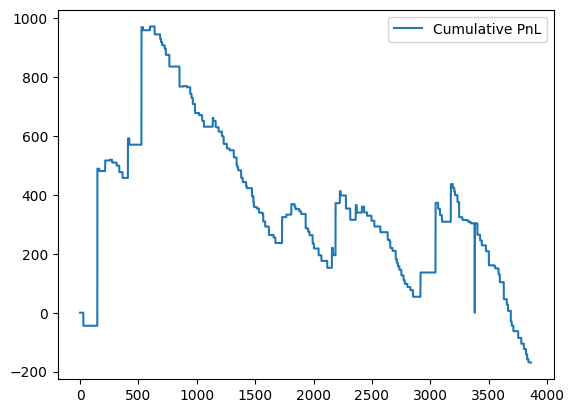

In [23]:
import matplotlib.pyplot as plt
# plt.plot(result['close'], label='Close Price')
# plt.plot(result['Donchian_High'], label='Donchian High')
# plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.plot(result['Cum_PnL'], label='Cumulative PnL')
plt.legend()
plt.show()

In [25]:
dirpath = 'data/IC'
direc = os.listdir(dirpath)
ttpnl = []
wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-4,:]

    result, trades = turtle_backtest(ff, channel_period=2, atr_period=2, add_threshold=0.1, stop_loss_mult=2.4)

    # 输出最后几行回测结果
    # print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

    day_pnl = 0
    # 输出交易记录
    # print("交易记录：")
    for trade in trades:
        day_pnl += trade.get('PnL', 0)
    ttpnl.append(day_pnl)
    print(day_pnl,file_name)

KeyError: "Column(s) ['InstrumentID'] do not exist"

In [166]:
local_path = 'E:/ryse/LocalDatabase'
code = 'IM'
# os.makedirs(f'data/{code}', exist_ok=True)
f = pd.read_csv(local_path + '/' + code + '.csv')

f = f[f['Date'] >= 20230302].reset_index(drop=True)

for dt in range(len(f['Date'])):
    date = f['Date'][dt]
    filename = f'{code}_{date}.csv'
    if not os.path.exists(f'data/{code}/{filename}'):
        print(f'Not Processed {filename}')
    if date == 20230829:
        continue

Not Processed IM_20230322.csv
Not Processed IM_20230428.csv
Not Processed IM_20230814.csv
Not Processed IM_20230829.csv
Not Processed IM_20250311.csv
Not Processed IM_20250312.csv
Not Processed IM_20250313.csv
Not Processed IM_20250314.csv
Not Processed IM_20250317.csv


In [18]:
ff = 1
def func():
    ff = 2
func()
ff

1